In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
np.random.seed(7)

## Step 1 — Simulate raw log data
A typical request log may include:

- `timestamp` (when the request happened)
- `endpoint` (route like `/api/login`)
- `method` (GET/POST)
- `status` (HTTP status code)
- `latency_ms` (response time)
- `bytes` (response size)
- `user_id` (anonymized)
- `region` (client region)
- `cache_hit` (whether cached)

We will intentionally add **messy values** (missing fields, wrong types, outliers) to make the processing realistic.





In [ ]:
#do step 1 here
import numpy as np
import pandas as pd

def simulate_logs(hours=24, house_count=10000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    n = hours * 60
    time_stamps = np.arange(1, n + 1)

    # Public car chargers (kWh per minute aggregated across city chargers)
    mu = 3.7876811131611228
    sigma = 0.8899150743790847
    public_car_chargers = np.random.lognormal(mean=mu, sigma=sigma, size=n)

    # Residential (kWh per minute aggregated across all houses)
    # Residential (kWh per minute aggregated across all houses) with daily pattern
    t = np.arange(n)
    hour = (t / 60) % 24

    # Two peaks: ~7–9am and ~6–9pm, with a baseline
    morning_peak = np.exp(-0.5 * ((hour - 7.5) / 1.6) ** 2)
    evening_peak  = np.exp(-0.5 * ((hour - 19.0) / 2.2) ** 2)
    baseline = 0.35 + 0.10 * np.cos((hour - 3) * 2 * np.pi / 24)  # slightly lower overnight

    shape = baseline + 0.75 * morning_peak + 1.10 * evening_peak
    shape = shape / shape.mean()  # keep overall daily energy comparable

    # Set a reasonable per-house kWh/day range and convert to total kWh/min
    per_house_kwh_day = np.random.uniform(18, 32)  # tweak for your scenario/season
    total_kwh_day = per_house_kwh_day * house_count
    mean_kwh_per_min = total_kwh_day / (24 * 60)

    # Minute-level variability + occasional short spikes (e.g., oven/dryer)
    noise = np.random.lognormal(mean=-0.05, sigma=0.25, size=n)  # multiplicative variability
    residential_house = mean_kwh_per_min * shape * noise

    spikes = np.random.rand(n) < 0.004
    residential_house[spikes] *= np.random.uniform(1.8, 3.5, size=spikes.sum())

    residential_house = residential_house.astype(float)  # keep as kWh (not int)


    # --- Added columns (kWh per minute) ---

    # 1) Small commercial load (shops/offices): higher during daytime
    day_shape = (np.sin((np.arange(n) / 60 - 6) * np.pi / 12) + 1) / 2  # 0..1 peak ~noon
    small_commercial = np.random.lognormal(mean=2.2, sigma=0.5, size=n) * (0.3 + 1.2 * day_shape)

    # 2) Streetlights: mostly at night
    hour = (np.arange(n) / 60) % 24
    is_night = (hour >= 18) | (hour <= 6)
    streetlights = np.where(
        is_night,
        np.random.normal(loc=35, scale=6, size=n),   # kWh/min aggregated
        np.random.normal(loc=4, scale=1.5, size=n)
    )
    streetlights = np.clip(streetlights, 0, None)

    # 3) Water treatment / pumping: fairly steady with occasional spikes
    water_treatment = np.random.normal(loc=55, scale=4, size=n)
    spikes = np.random.rand(n) < 0.01
    water_treatment[spikes] += np.random.uniform(80, 200, size=spikes.sum())
    water_treatment = np.clip(water_treatment, 0, None)

    # 4) HVAC load (city-wide): peaks afternoon; mild at night
    hvac = np.random.lognormal(mean=2.8, sigma=0.35, size=n) * (0.4 + 1.6 * day_shape)

    # 5) Solar generation (as negative load): only daytime
    solar = np.where(
        (hour >= 7) & (hour <= 17),
        np.random.normal(loc=120, scale=25, size=n) * day_shape,
        0
    )
    solar = np.clip(solar, 0, None)
    solar_generation = -solar  # negative kWh/min offsets demand

    df = pd.DataFrame({
        "TimeStamp": time_stamps,
        "public_car_chargers": public_car_chargers,
        "residential_house": residential_house,
        "small_commercial": small_commercial,
        "streetlights": streetlights,
        "water_treatment": water_treatment,
        "hvac_load": hvac,
        "solar_generation": solar_generation,
    })

    return df
df = simulate_logs()
print(df)

      TimeStamp  public_car_chargers  residential_house  small_commercial  \
0             1            33.881127                143          2.543445   
1             2            33.119290                277          3.901408   
2             3           184.490966                 62          1.836465   
3             4            29.734608                126          2.077602   
4             5             8.879299                207          2.916928   
...         ...                  ...                ...               ...   
1435       1436           153.873993                143          3.935803   
1436       1437           142.006830                198          4.117830   
1437       1438           111.494867                127          3.796130   
1438       1439            19.473101                164          2.300645   
1439       1440            57.070186                109          2.345983   

      streetlights  water_treatment  hvac_load  solar_generation  
0       

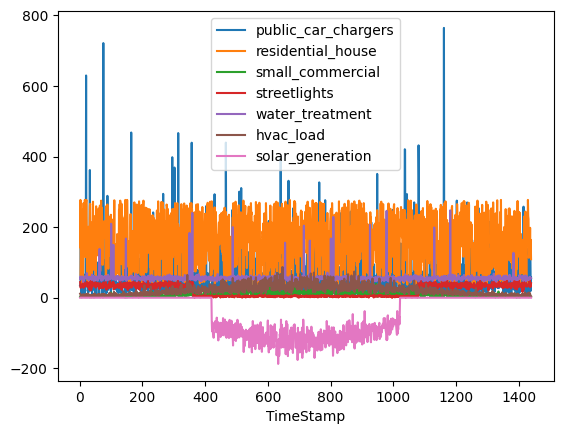

In [13]:
import matplotlib.pyplot as plt

x = df["TimeStamp"]

for col in df.columns:
    if col != "TimeStamp":
        plt.plot(x, df[col], label=col)

plt.xlabel("TimeStamp")
plt.legend()
plt.show()

## Step 2 — Basic DataFrame understanding
Key first steps:

1) `info()` (dtypes + missing values)
2) `describe()` for numeric columns
3) check for duplicates and missingness

raw.info()
raw.describe(include='all').T
# Missing values per column
raw.isna().sum().sort_values(ascending=False)


In [ ]:
#do step 2 here

## Step 3 — Cleaning and type fixes
Common issues we will fix:

- `timestamp` should be datetime
- `bytes` contains strings like `'12,345'`
- negative latency values
- missing endpoints

We'll produce a clean DataFrame called `df`.


In [ ]:
#do step 3 here

## Step 4 — Handling outliers (realistic)
Response time often has a long tail. We typically **cap** extreme values or remove them depending on context.

Here we will cap at the 99th percentile (winsorize) so plots are readable, but we keep the rows.

p99 = df["latency_ms"].quantile(0.99)
df["latency_ms_capped"] = df["latency_ms"].clip(upper=p99)

p99



In [ ]:
#do step 4 here

## Step 5 — Feature engineering
Feature engineering = creating useful columns for analysis.

We'll create:

- `minute` (timestamp floored to minute) for time aggregation
- `hour`
- `endpoint_group` (collapse `/api/items/123` into `/api/items/{id}`)
- `is_error`
- `latency_bucket` (fast/ok/slow)


In [ ]:
#do step 5 here

## Step 6 — Aggregations (the core of processing)
### A) Traffic over time
Requests per minute + error rate per minute.

In [ ]:
#do step 6 here

## Step 7 — A simple 'anomaly' idea (optional)
If time allows: flag minutes where traffic is unusually high.

We'll compute a rolling mean and find points above mean + 2*std.


In [ ]:
#do step 7 here

## Summary of what we did
- simulated messy, realistic CS log data
- loaded into a DataFrame
- inspected data types and missingness
- cleaned and fixed types
- capped outliers for readability
- engineered features for analysis
- aggregated (groupby) and visualized trends

This is the *standard data processing pipeline* you can reuse on many datasets.